In [1]:
!pip install transformers datasets pandas scikit-learn tqdm wandb openpyxl --quiet pandarallel

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # чтобы подавить предупреждения о параллелизме токенизаторов

import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    BertForSequenceClassification,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, roc_auc_score
from tqdm.auto import tqdm
from datasets import load_dataset, Dataset, DatasetDict
import wandb

from collections import Counter
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel

# Пути для сохранения моделей
BASE_SAVE_DIR = "/kaggle/working/models"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# Константы
RANDOM_STATE = 42
PANDARALLEL_WORKERS = 8

MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
MODEL_DICT = {
    "rubert-base": "DeepPavlov/rubert-base-cased",
    "rubert-large": "sberbank-ai/ruBert-large"
}

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.

2025-06-17 05:36:53.429061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750138613.645916      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750138613.710934      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from collections import Counter

tg_reserved_chars = [
    "_", "*", "[", "]", "(", ")", "~", "`", ">", "#", "+", "-", "=", "|", "{", "}", ".", "!"
]

def get_label2id_id2label(class_labels):
    id2label = dict(enumerate(class_labels))
    label2id = {i: label for label, i in id2label.items()}
    return label2id, id2label


def binarize_labels_with_zero_class(labels, num_labels):
    return [int(len(labels) == 0)] + [int(i in labels) for i in range(num_labels)]


def binarize_labels(labels, num_labels):
    return [int(i in labels) for i in range(num_labels)]


def binarize_labels_class_names(labels, class_names):
    return [int(i in labels) for i in class_names]


def sentiment_preprocessor(label):
    if label >= 1:
        return "positive"
    elif label == 0:
        return "neutral"
    elif label <= -1:
        return "negative"


def sentiment_postprocessor(label):
    if label == "neutral":
        return 0
    elif label == "positive":
        return 1
    elif label == "negative":
        return 2


def my_most_common(lst):
    data = Counter(lst)
    most_common = data.most_common()
    maximum_class = most_common[0][0]
    maximum_counter = most_common[0][1]

    for i in range(1, len(most_common)):
        if most_common[i][1] >= maximum_counter:
            return False
    return maximum_class


def save_model(model, tokenizer, directory):
    model.save_pretrained(directory)
    tokenizer.save_pretrained(directory)


def push_to_hub(model, tokenizer, name):
    model.push_to_hub(name)
    tokenizer.push_to_hub(name)


def fix_text(text):
    for char in tg_reserved_chars:
        text = text.replace(char, f"\\{char}")
    return text

In [4]:
# Метрики
THRESHOLD = 0.5

def get_report_multilabel(y_true, y_pred, target_names, output_dict=True):
    return classification_report(
        y_true,
        y_pred >= THRESHOLD,
        target_names=target_names,
        output_dict=output_dict,
        zero_division=0,
    )


def calculate_metrics_multilabel(y_true, y_pred, labels):
    target_names = list(labels.values())
    auc_macro = roc_auc_score(y_true, y_pred, average="macro")
    auc_micro = roc_auc_score(y_true, y_pred, average="micro")
    auc_weighted = roc_auc_score(y_true, y_pred, average="weighted")
    aucs = roc_auc_score(y_true, y_pred, average=None)

    report_dict = get_report_multilabel(
        y_true, y_pred, target_names=target_names, output_dict=True
    )
    report_dict["macro avg"]["auc-roc"]   = float(auc_macro)
    report_dict["micro avg"]["auc-roc"]   = float(auc_micro)
    report_dict["weighted avg"]["auc-roc"] = float(auc_weighted)
    for i, target in enumerate(target_names):
        report_dict[target]["auc-roc"] = float(aucs[i])
    return report_dict


def get_report_multiclass(y_true, y_pred, target_names, output_dict=True):
    return classification_report(
        y_true,
        np.argmax(y_pred, axis=-1),
        target_names=target_names,
        output_dict=output_dict,
        zero_division=0,
    )


def calculate_metrics_multiclass(y_true, y_pred, labels):
    target_names = list(labels.values())
    report_dict = get_report_multiclass(
        y_true, y_pred, target_names=target_names, output_dict=True
    )
    auc_macro = roc_auc_score(y_true, y_pred, multi_class="ovr", average="macro")
    auc_weighted = roc_auc_score(y_true, y_pred, multi_class="ovr", average="weighted")
    aucs = roc_auc_score(y_true, y_pred, multi_class="ovr", average=None)

    report_dict["macro avg"]["auc-roc"]   = float(auc_macro)
    report_dict["weighted avg"]["auc-roc"] = float(auc_weighted)
    for i, target in enumerate(target_names):
        report_dict[target]["auc-roc"] = float(aucs[i])
    report_dict.pop("accuracy", None)
    return report_dict


def calculate_metrics(y_true, y_pred, labels, problem_type):
    """
    problem_type = "single_label_classification" или "multi_label_classification"
    """
    if problem_type == "single_label_classification":
        return calculate_metrics_multiclass(y_true, y_pred, labels)
    elif problem_type == "multi_label_classification":
        return calculate_metrics_multilabel(y_true, y_pred, labels)
    else:
        raise ValueError(f"Unknown problem_type={problem_type}")


def eval(model, test_dataloader, labels, problem_type, return_debug=False):
    model.eval()
    test_y_true, test_y_pred, test_loss = predict(model, test_dataloader, problem_type)
    report_dict = calculate_metrics(test_y_true, test_y_pred, labels, problem_type)
    df = pd.DataFrame(report_dict).round(2)
    print(df)
    df.to_csv("/kaggle/working/final_run.csv")
    if return_debug:
        return test_y_true, test_y_pred, df
    return df

In [5]:
def predict(model, dataloader, problem_type):
    model.eval()
    val_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.inference_mode():
        for batch in tqdm(dataloader, desc="Predicting", leave=False):
            batch = batch.to(model.device)

            if problem_type == "multi_label_classification":
                batch["labels"] = batch["labels"].float()

            output = model(**batch)
            loss = output.loss
            val_loss += loss.item()

            y_true_list.append(batch["labels"].cpu())
            y_pred_list.append(output.logits.detach().cpu())

    avg_loss = val_loss / max(1, len(dataloader))
    all_true = torch.cat(y_true_list).numpy()
    all_logits = torch.cat(y_pred_list)

    if problem_type == "single_label_classification":
        all_probs = torch.softmax(all_logits, dim=-1).numpy()
    else:
        all_probs = torch.sigmoid(all_logits).numpy()

    return all_true, all_probs, avg_loss


from tqdm.auto import tqdm 

def train_epoch(model, train_dataloader, optimizer, problem_type):
    model.train()
    train_loss = 0.0
    y_true_list = []
    y_pred_list = []

    for batch in tqdm(train_dataloader, desc="Training batches", leave=False):
        batch = batch.to(model.device)

        if problem_type == "multi_label_classification":
            batch["labels"] = batch["labels"].float()

        output = model(**batch)
        loss = output.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        y_true_list.append(batch["labels"].cpu())
        y_pred_list.append(output.logits.detach().cpu())

    train_loss = train_loss / max(1, len(train_dataloader))

    all_true = torch.cat(y_true_list).numpy()
    all_logits = torch.cat(y_pred_list)

    if problem_type == "single_label_classification":
        all_probs = torch.softmax(all_logits, dim=-1).numpy()
    else:
        all_probs = torch.sigmoid(all_logits).numpy()

    return all_true, all_probs, train_loss

In [1]:
# Загрузка данных
def get_all_dataloaders(
    task: str,
    tokenizer,
    max_length: int,
    batch_size: int,
    shuffle: bool,
    num_workers: int,
    pin_memory: bool,
    drop_last: bool,
):
    data_collator = DataCollatorWithPadding(tokenizer)

    if task == "cedr":
        initial_num_labels = 5
        ds = load_dataset("cedr").map(
                lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
                batched=True,
            ).map(
                lambda x: {
                    "labels": [float(y) for y in binarize_labels_with_zero_class(x["labels"], initial_num_labels)]
                },
                batched=False,
                remove_columns=["text", "labels", "source"],
            )
        val_size = int((len(ds["train"]) + len(ds["test"])) * 0.1)
        train_val = ds["train"].train_test_split(test_size=val_size)
    
        data_collator = DataCollatorWithPadding(tokenizer)
    
        train_loader = DataLoader(
            train_val["train"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )
        val_loader = DataLoader(
            train_val["test"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )
        test_loader = DataLoader(
            ds["test"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )

    elif task == "goemotions":
        num_labels = 28
    
        ds = load_dataset("seara/ru_go_emotions", "simplified").map(
            lambda x: tokenizer(x["ru_text"], truncation=True, max_length=max_length),
            batched=True,
        ).map(
            lambda x: {"label": [float(y) for y in binarize_labels(x["labels"], num_labels)]},
            batched=False,
            remove_columns=["text", "labels", "id", "ru_text"],
        )


        train_loader = DataLoader(
            ds["train"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )
        val_loader = DataLoader(
            ds["validation"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )
        test_loader = DataLoader(
            ds["test"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=data_collator,
            pin_memory=pin_memory,
            drop_last=drop_last,
        )

    elif task == "custom":
        pandarallel.initialize(progress_bar=False, nb_workers=PANDARALLEL_WORKERS)
        entity_df = pd.read_csv("/kaggle/input/sentiment-emotion-dataset/data/RuNewsSent/train_data.csv", sep=None, engine="python").dropna()
        entity_df = entity_df.rename(columns={"sentence": "text"})
        entity_df = entity_df[entity_df["label"].isin([-1, 0, 1])].copy()
        entity_df = entity_df[["text", "label"]].copy()
        entity_df["label"] = entity_df["label"].apply(sentiment_preprocessor)
        entity_df["text"] = entity_df["text"].str.replace(r"[\n\t]", " ", regex=True)
        entity_train, entity_temp = train_test_split(entity_df, test_size=0.2, random_state=RANDOM_STATE)
        entity_val, entity_test = train_test_split(entity_temp, test_size=0.5, random_state=RANDOM_STATE)

        lc15 = pd.read_excel(
            "/kaggle/input/sentiment-emotion-dataset/data/linis-crowd-2015/text_rating_final.xlsx",
            header=None, names=["text", "label"]
        ).dropna()
        lc16 = pd.read_excel(
            "/kaggle/input/sentiment-emotion-dataset/data/linis-crowd-2016/doc_comment_summary.xlsx",
            header=None, names=["text", "label"]
        ).dropna()
        lc = pd.concat([lc15, lc16], ignore_index=True)
        lc = lc[lc["label"].isin([-2, -1, 0, 1, 2])].copy()
        lc["label"] = lc["label"].apply(sentiment_preprocessor)
        lc["text"] = lc["text"].str.replace(r"[\n\t]", " ", regex=True)
        lc["occur"] = lc["text"].parallel_apply(lambda t: (lc["text"] == t).sum())
        lc = lc[lc["occur"] >= 3]

        mapping = {}
        for t, lbl in zip(lc["text"], lc["label"]):
            mapping.setdefault(t, []).append(lbl)
        final_map = {}
        for t, lbls in mapping.items():
            mc = my_most_common(lbls)
            if mc is not False:
                final_map[t] = mc
        lc_df = pd.DataFrame(final_map.items(), columns=["text", "label"])
        vt = int(len(lc_df) * 0.1)
        lc_train, lc_temp = train_test_split(
            lc_df, test_size=vt, shuffle=True, random_state=RANDOM_STATE
        )
        lc_val, lc_test = train_test_split(
            lc_temp, test_size=0.5, shuffle=True, random_state=RANDOM_STATE
        )

        # — RuReviews —
        rr = pd.read_csv(
            "/kaggle/input/sentiment-emotion-dataset/data/ru-reviews/women-clothing-accessories.3-class.balanced.csv",
            sep="\t", names=["text", "label"], skiprows=1
        )
        rr["label"] = rr["label"].replace({"neautral": "neutral"})
        rr["text"]  = rr["text"].str.replace(r"[\n\t]", " ", regex=True)
        vt = int(len(rr) * 0.1)
        rr_train, rr_temp = train_test_split(rr, test_size=vt, shuffle=True, random_state=RANDOM_STATE)
        rr_val, rr_test   = train_test_split(rr_temp, test_size=0.5, shuffle=True, random_state=RANDOM_STATE)

        # — RuSentiment —
        rus_rand = pd.read_csv("/kaggle/input/sentiment-emotion-dataset/data/ru-sentiment/rusentiment_random_posts.csv")
        rus_act  = pd.read_csv("/kaggle/input/sentiment-emotion-dataset/data/ru-sentiment/rusentiment_preselected_posts.csv")
        rus_test = pd.read_csv("/kaggle/input/sentiment-emotion-dataset/data/ru-sentiment/rusentiment_test.csv")
        rus_tv   = pd.concat([rus_act, rus_rand], ignore_index=True)
        rus_tv   = rus_tv[rus_tv["label"].isin(["positive", "negative", "neutral"])].copy()
        rus_test = rus_test[rus_test["label"].isin(["positive", "negative", "neutral"])].copy()
        rus_tv["text"]   = rus_tv["text"].str.replace(r"[\n\t]", " ", regex=True)
        rus_test["text"] = rus_test["text"].str.replace(r"[\n\t]", " ", regex=True)
        vt = int((len(rus_tv) + len(rus_test)) * 0.09)
        rs_train, rs_val = train_test_split(rus_tv, test_size=vt, shuffle=True, random_state=RANDOM_STATE)

        # — Kaggle Russian News —
        kag = pd.read_json("/kaggle/input/sentiment-emotion-dataset/data/kaggle-ru-news/train.json").drop("id", axis=1)
        kag.columns = ["text", "label"]
        kag["text"] = kag["text"].str.replace(r"[\n\t]", " ", regex=True)
        vt = int(len(kag) * 0.1)
        kg_train, kg_temp = train_test_split(kag, test_size=vt, shuffle=True, random_state=RANDOM_STATE)
        kg_val, kg_test   = train_test_split(kg_temp, test_size=0.5, shuffle=True, random_state=RANDOM_STATE)

        train_df = pd.concat([lc_train, rr_train, rs_train, kg_train, entity_train], ignore_index=True)
        val_df   = pd.concat([lc_val,   rr_val,   rs_val,   kg_val,   entity_val],   ignore_index=True)
        test_df  = pd.concat([lc_test,  rr_test,  rus_test, kg_test,  entity_test],  ignore_index=True)
        train_df = train_df.dropna(subset=["text", "label"])
        val_df   = val_df.dropna(subset=["text", "label"])
        test_df  = test_df.dropna(subset=["text", "label"])
        ds = DatasetDict({
            "train": Dataset.from_pandas(train_df, preserve_index=False),
            "val":   Dataset.from_pandas(val_df,   preserve_index=False),
            "test":  Dataset.from_pandas(test_df,  preserve_index=False),
        })
        ds = ds.map(
            lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
            batched=True
        ).map(
            lambda x: {"labels": sentiment_postprocessor(x["label"])},
            batched=False,
            remove_columns=["text", "label"]
        )

        train_loader = DataLoader(
            ds["train"], batch_size=batch_size, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
            collate_fn=data_collator, drop_last=drop_last
        )
        val_loader = DataLoader(
            ds["val"], batch_size=batch_size, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
            collate_fn=data_collator, drop_last=drop_last
        )
        test_loader = DataLoader(
            ds["test"], batch_size=batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=pin_memory,
            collate_fn=data_collator, drop_last=drop_last
        )

    else:
        raise ValueError(f"Unknown task: {task}")

    print(
        f"Loaded dataloaders for «{task}»:",
        f"train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}"
    )
    return train_loader, val_loader, test_loader

In [7]:
def get_model(model_name, labels, num_labels, problem_type, task):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if task == "train":
        label2id, id2label = get_label2id_id2label(labels.values())
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type=problem_type, 
            label2id=label2id,
            id2label=id2label,
        )
        print("Loaded pretrained encoder")
    else:  
        model = BertForSequenceClassification.from_pretrained(model_name)
        print("Loaded pretrained model")
    return tokenizer, model


def task_play(TASK_NAME):

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if TASK_NAME == "cedr":
        labels = {0: "no_label", 1: "anger", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise"}
        num_labels = 6
        problem_type = "multi_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="cedr",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    elif TASK_NAME == "goemotions":
        go_dataset = load_dataset("seara/ru_go_emotions", "simplified")
        go_labels = go_dataset["train"].features["labels"].feature.names
        labels = {i: lbl for i, lbl in enumerate(go_labels)}
        num_labels = len(labels)
        problem_type = "multi_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="goemotions",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    elif TASK_NAME == "custom":
        labels = {0: "neutral", 1: "positive", 2: "negative"}
        num_labels = 3
        problem_type = "single_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="custom",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    else:
        raise ValueError(f"Неизвестный TASK: {TASK_NAME}")

    return labels, num_labels, problem_type, tokenizer, train_loader, val_loader, test_loader

In [8]:
def train(
    model,
    train_dataloader,
    optimizer,
    epochs,
    val_dataloader,
    test_dataloader,
    labels,
    problem_type,
    log_wandb,
):
    tq = tqdm(range(epochs))
    for epoch in tq:
        model.train()
        train_y_true, train_y_pred, train_loss = train_epoch(
            model, train_dataloader, optimizer, problem_type
        )

        model.eval()
        val_y_true, val_y_pred, val_loss = predict(model, val_dataloader, problem_type)

        report_dict = calculate_metrics(val_y_true, val_y_pred, labels, problem_type)

        if log_wandb:
            wandb_dict = report_dict.copy()
            for label in labels.values():
                wandb_dict.pop(label, None)
            wandb_dict.pop("samples avg", None)
            wandb_dict.pop("weighted avg", None)
            for key in list(wandb_dict.keys()):
                if isinstance(wandb_dict[key], dict):
                    wandb_dict[key].pop("support", None)
            wandb.log({"train_loss": train_loss, "val_loss": val_loss, **wandb_dict})

        tq.set_description(f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    df = eval(model, test_dataloader, labels, problem_type)

    if log_wandb:
        table = wandb.Table(dataframe=df.rename_axis("metric").reset_index())
        wandb.log({"table": table})

    return df

In [25]:
BATCH_SIZE = 32
EPOCHS = 1
model_name = MODEL_DICT["rubert-base"]
print(f"===== Обучение для модели: {model_name} =====")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tasks = ["custom", "cedr","goemotions"]

for TASK_NAME in tasks:
    labels, num_labels, problem_type, tokenizer, train_loader, val_loader, test_loader = task_play(TASK_NAME)
    print(f"{TASK_NAME}, метки = {labels}")

    _, model = get_model(model_name, labels, num_labels, problem_type, task="train")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LR)

    df_test = train(
        model,
        train_loader,
        optimizer,
        epochs=EPOCHS,
        val_dataloader=val_loader,
        test_dataloader=test_loader,
        labels=labels,
        problem_type=problem_type,
        log_wandb=False
    )

    save_dir = os.path.join(BASE_SAVE_DIR, model_name.split("/")[-1], TASK_NAME)
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    df_test.to_csv(os.path.join(save_dir, "/kaggle/working/goemo-base-metrics.csv"))
    print(f"Модель «{TASK_NAME}» сохранена в «{save_dir}»")
    print(f"Итоговые тест метрики для «{TASK_NAME}»:{df_test.round(2)}")

===== Обучение для модели: DeepPavlov/rubert-base-cased =====


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Loaded dataloaders for «goemotions»: train=1357, val=170, test=170
goemotions, метки = {0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pretrained encoder


  0%|          | 0/3 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


           admiration  amusement   anger  annoyance  approval  caring  \
precision        0.61       0.76    0.52       1.00      0.50    0.60   
recall           0.68       0.86    0.28       0.01      0.23    0.16   
f1-score         0.64       0.81    0.36       0.01      0.32    0.25   
support        504.00     264.00  198.00     320.00    351.00  135.00   
auc-roc          0.93       0.97    0.89       0.82      0.81    0.87   

           confusion  curiosity  desire  disappointment  ...  realization  \
precision       0.49       0.48    0.53            0.56  ...         0.00   
recall          0.29       0.57    0.35            0.03  ...         0.00   
f1-score        0.36       0.52    0.42            0.06  ...         0.00   
support       153.00     284.00   83.00          151.00  ...       145.00   
auc-roc         0.93       0.95    0.93            0.83  ...         0.73   

           relief  remorse  sadness  surprise  neutral  micro avg  macro avg  \
precision    0.00 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
BATCH_SIZE = 32
EPOCHS = 1
model_name = MODEL_DICT["rubert-large"]
print(f"===== Обучение для модели: {model_name} =====")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tasks = ["custom", "cedr","goemotions"]

for TASK_NAME in tasks:
    labels, num_labels, problem_type, tokenizer, train_loader, val_loader, test_loader = task_play(TASK_NAME)
    print(f"{TASK_NAME}, метки = {labels}")

    _, model = get_model(model_name, labels, num_labels, problem_type, task="train")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LR)

    df_test = train(
        model,
        train_loader,
        optimizer,
        epochs=EPOCHS,
        val_dataloader=val_loader,
        test_dataloader=test_loader,
        labels=labels,
        problem_type=problem_type,
        log_wandb=False
    )

    save_dir = os.path.join(BASE_SAVE_DIR, model_name.split("/")[-1], TASK_NAME)
    os.makedirs(save_dir, exist_ok=True)
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    df_test.to_csv(os.path.join(save_dir, "/kaggle/working/large-metrics.csv"))
    print(f"Модель «{TASK_NAME}» сохранена в «{save_dir}»")
    print(f"Итоговые тест метрики для «{TASK_NAME}»:{df_test.round(2)}")

===== Обучение для модели: sberbank-ai/ruBert-large =====


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

(…)-00000-of-00001-46692d7e0c0147a4.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

(…)-00000-of-00001-9e6cdf9c1f2a20a4.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

(…)-00000-of-00001-0acb4be83ca6567e.parquet:   0%|          | 0.00/761k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Loaded dataloaders for «goemotions»: train=1357, val=170, test=170
goemotions, метки = {0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pretrained encoder


  0%|          | 0/1 [00:00<?, ?it/s]

Training batches:   0%|          | 0/1357 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


           admiration  amusement   anger  annoyance  approval  caring  \
precision        0.65       0.76    0.61       0.00      0.68    0.00   
recall           0.66       0.84    0.19       0.00      0.21    0.00   
f1-score         0.65       0.80    0.29       0.00      0.32    0.00   
support        504.00     264.00  198.00     320.00    351.00  135.00   
auc-roc          0.95       0.96    0.88       0.81      0.83    0.88   

           confusion  curiosity  desire  disappointment  ...  realization  \
precision       0.67       0.62    0.68            0.00  ...         0.00   
recall          0.03       0.15    0.31            0.00  ...         0.00   
f1-score        0.05       0.24    0.43            0.00  ...         0.00   
support       153.00     284.00   83.00          151.00  ...       145.00   
auc-roc         0.93       0.95    0.93            0.82  ...         0.72   

           relief  remorse  sadness  surprise  neutral  micro avg  macro avg  \
precision    0.00 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

Loaded dataloaders for «cedr»: train=206, val=30, test=59


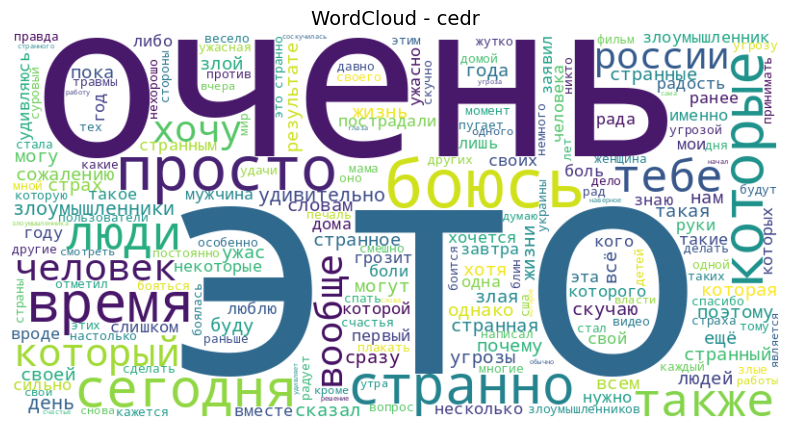

Loaded dataloaders for «goemotions»: train=1357, val=170, test=170


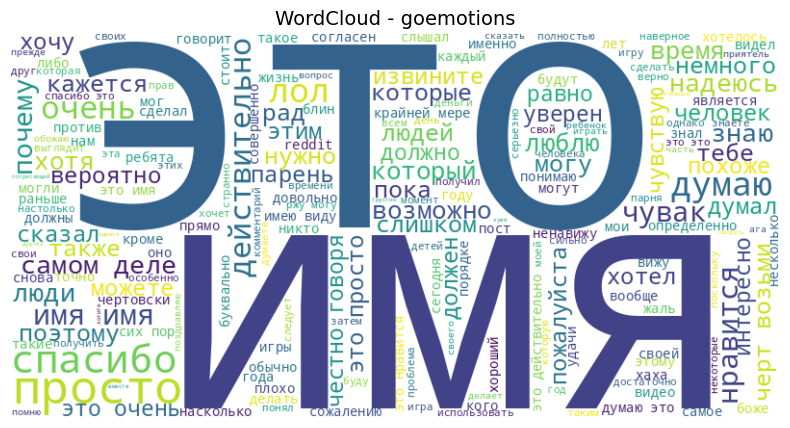

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Loaded dataloaders for «custom»: train=3688, val=249, test=253


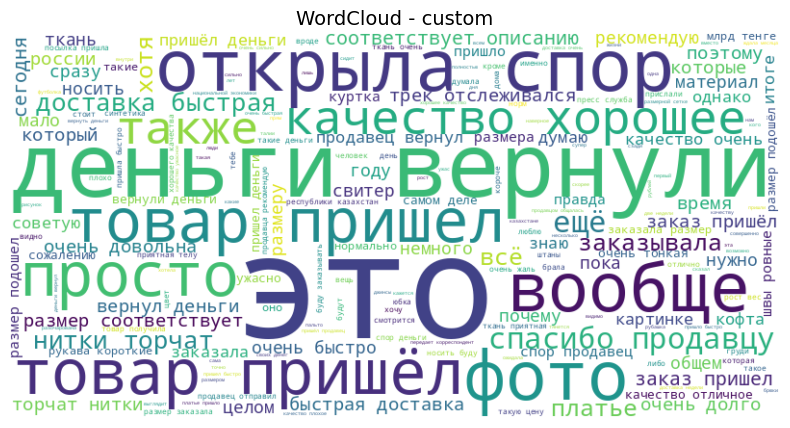

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

def extract_texts_from_loader(loader, tokenizer):
    all_texts = []
    for batch in loader:
        input_ids = batch["input_ids"]
        for ids in input_ids:
            text = tokenizer.decode(ids, skip_special_tokens=True)
            all_texts.append(text)
    return all_texts

russian_stopwords = set(stopwords.words("russian"))

def clean_text(text):
    # убираем символы, оставляем только слова
    words = re.findall(r'\b\w+\b', text.lower())
    return " ".join([word for word in words if word not in russian_stopwords and len(word) > 2])

def plot_wordcloud(texts, title):
    cleaned = [clean_text(t) for t in texts]
    all_text = " ".join(cleaned)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()


for task in ["cedr", "goemotions", "custom"]:
    labels, num_labels, problem_type, tokenizer, train_loader, _, _ = task_play(task)
    texts = extract_texts_from_loader(train_loader, tokenizer)
    plot_wordcloud(texts, f"WordCloud - {task}")

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from pathlib import Path
import torch, numpy as np

MAX_LENGTH   = 128
BATCH_SIZE   = 16   
NUM_WORKERS  = 8
PIN_MEMORY   = True
DROP_LAST    = False
base_path    = Path("/kaggle/input/sentiment-emotion-models")

tokenizer = AutoTokenizer.from_pretrained(base_path / "ruBert-base-cased/custom")
_, val_loader, test_loader = get_all_dataloaders(
    task="custom",
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=DROP_LAST
)

model_base  = AutoModelForSequenceClassification.from_pretrained(base_path / "ruBert-base-cased/custom").cuda().eval()
model_large = AutoModelForSequenceClassification.from_pretrained(base_path / "ruBert-large/custom").cuda().eval()
models = [model_base, model_large]

def collect_features(loader):
    all_features, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids      = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels         = batch["labels"].cpu().numpy()
            all_labels.append(labels)

            probs = []
            for model in models:
                logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
                probs.append(softmax(logits, dim=1).cpu().numpy())
            stacked_probs = np.concatenate(probs, axis=1) 
            all_features.append(stacked_probs)

    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)

X_val, y_val = collect_features(val_loader)
stack_model = LogisticRegression(max_iter=1000, multi_class="multinomial")
stack_model.fit(X_val, y_val)

X_test, y_test = collect_features(test_loader)
y_pred = stack_model.predict(X_test)

print("=== STACKING (LogReg) on custom TEST set ===")
print(classification_report(
    y_test, y_pred,
    target_names=["neutral", "positive", "negative"]
))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Loaded dataloaders for «custom»: train=7375, val=498, test=506
=== STACKING (LogReg) on custom TEST set ===
              precision    recall  f1-score   support

     neutral       0.74      0.76      0.75      3787
    positive       0.80      0.81      0.81      2255
    negative       0.72      0.67      0.70      2042

    accuracy                           0.75      8084
   macro avg       0.75      0.75      0.75      8084
weighted avg       0.75      0.75      0.75      8084



In [9]:
def task_play(TASK_NAME,tokenizer):

    if TASK_NAME == "cedr":
        labels = {0: "no_label", 1: "anger", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise"}
        num_labels = 6
        problem_type = "multi_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="cedr",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    elif TASK_NAME == "goemotions":
        go_dataset = load_dataset("seara/ru_go_emotions", "simplified")
        go_labels = go_dataset["train"].features["labels"].feature.names
        labels = {i: lbl for i, lbl in enumerate(go_labels)}
        num_labels = len(labels)
        problem_type = "multi_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="goemotions",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    elif TASK_NAME == "custom":
        labels = {0: "neutral", 1: "positive", 2: "negative"}
        num_labels = 3
        problem_type = "single_label_classification"
        train_loader, val_loader, test_loader = get_all_dataloaders(
            task="custom",
            tokenizer=tokenizer,
            max_length=MAX_LENGTH,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=False
        )

    else:
        raise ValueError(f"Неизвестный TASK: {TASK_NAME}")

    return labels, num_labels, problem_type, tokenizer, train_loader, val_loader, test_loader

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Loaded dataloaders for «custom»: train=3688, val=249, test=253

===== Метрики для: ruBert-base-cased =====
              precision    recall  f1-score   support

     neutral       0.75      0.73      0.74      3787
    positive       0.80      0.81      0.80      2255
    negative       0.69      0.70      0.69      2042

    accuracy                           0.75      8084
   macro avg       0.74      0.75      0.75      8084
weighted avg       0.75      0.75      0.75      8084



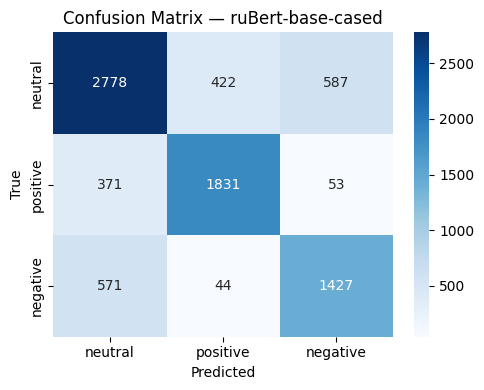


===== Метрики для: ruBert-large =====
              precision    recall  f1-score   support

     neutral       0.48      0.66      0.56      3787
    positive       0.28      0.03      0.05      2255
    negative       0.29      0.39      0.33      2042

    accuracy                           0.41      8084
   macro avg       0.35      0.36      0.31      8084
weighted avg       0.38      0.41      0.36      8084



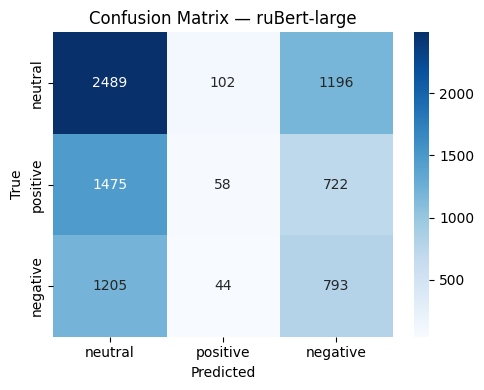

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from pathlib import Path

base_path = Path("/kaggle/input/sentiment-emotion-models")
task = "custom"
model_names = ["ruBert-base-cased", "ruBert-large"]
label_map = {0: "neutral", 1: "positive", 2: "negative"}
MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = False

# ── 2. Функция получения предсказаний ─────────────────────────
def get_predictions(model, dataloader):
    all_probs, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['labels'].cpu().numpy()
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels)
    y_true = np.concatenate(all_labels)
    y_probs = np.concatenate(all_probs)
    y_pred = np.argmax(y_probs, axis=1)
    return y_true, y_pred

# ── 3. Загрузка tokenizer один раз ────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(base_path / model_names[0] / task)

# ── 4. Получение test_loader ──────────────────────────────────
_, _, test_loader = get_all_dataloaders(
    task="custom",
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=DROP_LAST,
)

# ── 5. Обход по моделям ───────────────────────────────────────
for model_name in model_names:
    model_path = base_path / model_name / task
    print(f"\n===== Метрики для: {model_name} =====")
    
    model = AutoModelForSequenceClassification.from_pretrained(model_path).cuda().eval()
    y_true, y_pred = get_predictions(model, test_loader)
    
    # Метрики
    print(classification_report(y_true, y_pred, target_names=label_map.values()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
    confusion_matrix,
)
from torch.nn.functional import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from pathlib import Path

# ──────────────────────────────────────────────────────────────
# 1. Пути и общие параметры
# ──────────────────────────────────────────────────────────────
base_path = Path("/kaggle/input/sentiment-emotion-models")   # где лежат ваши сохранённые модели
save_path = Path("/kaggle/working/reports")                  # куда класть отчёты
save_path.mkdir(parents=True, exist_ok=True)

tasks = {
    "cedr": {
        "label_map": {
            0: "no_label",
            1: "anger",
            2: "fear",
            3: "joy",
            4: "sadness",
            5: "surprise",
        },
        "problem_type": "multi_label_classification",
    },
    "goemotions": {
        "label_map": {
            i: lbl
            for i, lbl in enumerate(
                [
                    "admiration",
                    "amusement",
                    "anger",
                    "annoyance",
                    "approval",
                    "caring",
                    "confusion",
                    "curiosity",
                    "desire",
                    "disappointment",
                    "disapproval",
                    "disgust",
                    "embarrassment",
                    "excitement",
                    "fear",
                    "gratitude",
                    "grief",
                    "joy",
                    "love",
                    "nervousness",
                    "optimism",
                    "pride",
                    "realization",
                    "relief",
                    "remorse",
                    "sadness",
                    "surprise",
                    "neutral",
                ]
            )
        },
        "problem_type": "multi_label_classification",
    },
    "custom": {
        "label_map": {0: "neutral", 1: "positive", 2: "negative"},
        "problem_type": "single_label_classification",
    },
}

model_names = ["ruBert-base-cased", "ruBert-large"]

MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = False
THRESHOLD = 0.5


# ──────────────────────────────────────────────────────────────
# 2. Универсальное предсказание
# ──────────────────────────────────────────────────────────────
def get_predictions(model, dataloader, problem_type: str):
    """Возвращает y_true, y_pred (уже порогованные для multi-label)."""
    all_probs, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["labels"].cpu().numpy()

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

            if problem_type == "single_label_classification":
                probs = torch.softmax(logits, dim=1).cpu().numpy()
            else:
                probs = sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(labels)

    y_true = np.concatenate(all_labels)
    y_probs = np.concatenate(all_probs)

    if problem_type == "single_label_classification":
        y_pred = np.argmax(y_probs, axis=1)
    else:
        y_pred = (y_probs >= THRESHOLD).astype(int)

    return y_true, y_pred

# ──────────────────────────────────────────────────────────────
# 4. Основной цикл
# ──────────────────────────────────────────────────────────────
for task_name, cfg in tasks.items():
    label_map = cfg["label_map"]
    problem_type = cfg["problem_type"]

    # один токенайзер на задачу
    tokenizer = AutoTokenizer.from_pretrained(base_path / model_names[0] / task_name)

    # test-loader (без перемешивания)
    _, _, test_loader = get_all_dataloaders(
        task=task_name,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        drop_last=DROP_LAST,
    )

    for model_name in model_names:
        print(f"\n {task_name.upper()} — модель: {model_name}")

        # ── загрузка модели
        model_path = base_path / model_name / task_name
        model = AutoModelForSequenceClassification.from_pretrained(model_path).cuda()

        # ── предсказание
        y_true, y_pred = get_predictions(model, test_loader, problem_type)

        # ── отчёт (classification_report)
        report = classification_report(
            y_true,
            y_pred,
            target_names=list(label_map.values()),
            output_dict=True,
            zero_division=0,
        )
        df_report = pd.DataFrame(report).T.round(3)
        csv_file = save_path / f"{task_name}_{model_name}_metrics.csv"
        df_report.to_csv(csv_file)
        print(f"Отчёт сохранён: {csv_file}")

        # ── aggregated confusion-matrix
        if problem_type == "multi_label_classification":
            # складываем все ml-confusion-matrix по классам
            ml_cm = multilabel_confusion_matrix(y_true, y_pred)
            cm_agg = ml_cm.sum(axis=0)
        else:
            cm_agg = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(4, 3))
        sns.heatmap(
            cm_agg,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"]
            if problem_type == "multi_label_classification"
            else list(label_map.values()),
            yticklabels=["True 0", "True 1"]
            if problem_type == "multi_label_classification"
            else list(label_map.values()),
        )
        plt.title(f"CM — {model_name} ({task_name})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()

        png_file = save_path / f"{task_name}_{model_name}_confusion.png"
        plt.savefig(png_file)
        plt.close()
        print(f"Матрица сохранена: {png_file}")


Loaded dataloaders for «cedr»: train=206, val=30, test=59

 CEDR — модель: ruBert-base-cased
Отчёт сохранён: /kaggle/working/reports/cedr_ruBert-base-cased_metrics.csv
Матрица сохранена: /kaggle/working/reports/cedr_ruBert-base-cased_confusion.png

 CEDR — модель: ruBert-large
Отчёт сохранён: /kaggle/working/reports/cedr_ruBert-large_metrics.csv
Матрица сохранена: /kaggle/working/reports/cedr_ruBert-large_confusion.png
Loaded dataloaders for «goemotions»: train=1357, val=170, test=170

 GOEMOTIONS — модель: ruBert-base-cased
Отчёт сохранён: /kaggle/working/reports/goemotions_ruBert-base-cased_metrics.csv
Матрица сохранена: /kaggle/working/reports/goemotions_ruBert-base-cased_confusion.png

 GOEMOTIONS — модель: ruBert-large
Отчёт сохранён: /kaggle/working/reports/goemotions_ruBert-large_metrics.csv
Матрица сохранена: /kaggle/working/reports/goemotions_ruBert-large_confusion.png
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data betwe

Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Map:   0%|          | 0/117995 [00:00<?, ? examples/s]

Map:   0%|          | 0/7965 [00:00<?, ? examples/s]

Map:   0%|          | 0/8084 [00:00<?, ? examples/s]

Loaded dataloaders for «custom»: train=3688, val=249, test=253

 CUSTOM — модель: ruBert-base-cased
Отчёт сохранён: /kaggle/working/reports/custom_ruBert-base-cased_metrics.csv
Матрица сохранена: /kaggle/working/reports/custom_ruBert-base-cased_confusion.png

 CUSTOM — модель: ruBert-large
Отчёт сохранён: /kaggle/working/reports/custom_ruBert-large_metrics.csv
Матрица сохранена: /kaggle/working/reports/custom_ruBert-large_confusion.png


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, auc
from torch.nn.functional import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from itertools import cycle
from pathlib import Path

# ── Настройки ─────────────────────────────
base_path = Path("/kaggle/input/sentiment-emotion-models")
save_path = Path("/kaggle/working/reports")
model_names = ["ruBert-base-cased", "ruBert-large"]
MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = False

# ── Карты меток ───────────────────────────
tasks = {
    "cedr": {
        "label_map": {0: "no_label", 1: "anger", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise"},
    },
    "goemotions": {
        "label_map": {
            i: lbl for i, lbl in enumerate([
                "admiration", "amusement", "anger", "annoyance", "approval", "caring",
                "confusion", "curiosity", "desire", "disappointment", "disapproval",
                "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
                "joy", "love", "nervousness", "optimism", "pride", "realization",
                "relief", "remorse", "sadness", "surprise", "neutral"
            ])
        },
    }
}

# ── ROC-кривые ─────────────────────────────
def plot_roc_curves(y_true, y_probs, label_map, task, model_name):
    n_classes = len(label_map)
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(7, 6))
    colors = cycle(sns.color_palette("husl", n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], lw=2, color=color, label=f"{label_map[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', label=f"Macro AUC = {roc_auc['macro']:.2f}", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {task.upper()} — {model_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()

    file_path = save_path / f"{task}_{model_name}_roc_auc.png"
    plt.savefig(file_path)
    plt.close()
    print(f"ROC-кривая сохранена: {file_path}")

# ── Предсказания ────────────────────────────
def get_probs(model, dataloader):
    all_probs, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['labels'].cpu().numpy()
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels)
    return np.concatenate(all_labels), np.concatenate(all_probs)

# ── Цикл ─────────────────────────────────────
for task, info in tasks.items():
    label_map = info["label_map"]
    tokenizer = AutoTokenizer.from_pretrained(base_path / model_names[0] / task)

    _, _, test_loader = get_all_dataloaders(
        task=task,
        tokenizer=tokenizer,
        max_length=MAX_LENGTH,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=8,
        pin_memory=PIN_MEMORY,
        drop_last=DROP_LAST,
    )

    for model_name in model_names:
        model_path = base_path / model_name / task
        model = AutoModelForSequenceClassification.from_pretrained(model_path).cuda().eval()
        y_true, y_probs = get_probs(model, test_loader)
        plot_roc_curves(y_true, y_probs, label_map, task, model_name)


Loaded dataloaders for «cedr»: train=206, val=30, test=59
ROC-кривая сохранена: /kaggle/working/reports/cedr_ruBert-base-cased_roc_auc.png
ROC-кривая сохранена: /kaggle/working/reports/cedr_ruBert-large_roc_auc.png
Loaded dataloaders for «goemotions»: train=1357, val=170, test=170
ROC-кривая сохранена: /kaggle/working/reports/goemotions_ruBert-base-cased_roc_auc.png
ROC-кривая сохранена: /kaggle/working/reports/goemotions_ruBert-large_roc_auc.png


In [21]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.nn.functional import softmax, sigmoid
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
    roc_curve,
    auc,
)
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Пути
BASE_PATH    = Path("/kaggle/input/sentiment-emotion-models")
SAVE_REPORTS = Path("/kaggle/working/ensemble_reports")
SAVE_MODELS  = Path("/kaggle/working/ensemble_models")
SAVE_REPORTS.mkdir(exist_ok=True, parents=True)
SAVE_MODELS.mkdir(exist_ok=True, parents=True)

TASKS = {
    "cedr": {
        "label_map": {0: "no_label", 1: "anger", 2: "fear", 3: "joy", 4: "sadness", 5: "surprise"},
        "problem_type": "multi_label_classification",
    },
    "goemotions": {
        "label_map": {
            i: lbl for i, lbl in enumerate([
                "admiration","amusement","anger","annoyance","approval","caring",
                "confusion","curiosity","desire","disappointment","disapproval","disgust",
                "embarrassment","excitement","fear","gratitude","grief","joy","love",
                "nervousness","optimism","pride","realization","relief","remorse",
                "sadness","surprise","neutral"
            ])
        },
        "problem_type": "multi_label_classification",
    },
}

MODEL_NAMES = ["ruBert-base-cased", "ruBert-large"]
MAX_LENGTH  = 128
BATCH_SIZE  = 32
NUM_WORKERS = 8
PIN_MEMORY  = True
DROP_LAST   = False
THRESHOLD   = 0.5
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

def get_probs(model, loader, problem_type):
    model.to(DEVICE).eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels         = batch["labels"].cpu().numpy()
            logits         = model(input_ids=input_ids, attention_mask=attention_mask).logits
            if problem_type == "single_label_classification":
                probs = softmax(logits, dim=1).cpu().numpy()
            else:
                probs = sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels)
    return np.concatenate(all_labels), np.concatenate(all_probs)

def plot_roc(y_true, y_probs, label_map, task, method, problem_type):
    if problem_type == "single_label_classification":
        classes    = list(label_map.keys())
        y_true_bin = label_binarize(y_true, classes=classes)
    else:
        y_true_bin = y_true
    n_classes = y_true_bin.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i]         = auc(fpr[i], tpr[i])
    all_fpr  = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = sum(np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)) / n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(all_fpr, mean_tpr)
    plt.figure(figsize=(6,5))
    colors = cycle(sns.color_palette("husl", n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"{label_map[i]} (AUC={roc_auc[i]:.2f})")
    plt.plot(fpr["macro"], tpr["macro"], color="black", lw=2, linestyle="--",
             label=f"macro (AUC={roc_auc['macro']:.2f})")
    plt.plot([0,1],[0,1],"k--", lw=1)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC — {task.upper()} — {method}")
    plt.legend(loc="lower right"); plt.tight_layout()
    out = SAVE_REPORTS / f"{task}_{method}_roc.png"
    plt.savefig(out); plt.close()
    print(f"→ ROC saved: {out}")

for task_name, cfg in TASKS.items():
    label_map    = cfg["label_map"]
    problem_type = cfg["problem_type"]
    print(f"\n==== ENSEMBLE FOR {task_name.upper()} ====")

    tokenizer       = AutoTokenizer.from_pretrained(BASE_PATH / MODEL_NAMES[0] / task_name)
    _, val_loader, test_loader = get_all_dataloaders(
        task       = task_name,
        tokenizer  = tokenizer,
        max_length = MAX_LENGTH,
        batch_size = BATCH_SIZE,
        shuffle    = False,
        num_workers= NUM_WORKERS,
        pin_memory = PIN_MEMORY,
        drop_last  = DROP_LAST,
    )

    val_feats, test_feats = [], []
    for m in MODEL_NAMES:
        print(f"→ loading {m}")
        model = AutoModelForSequenceClassification.from_pretrained(BASE_PATH/m/task_name)
        yv, pv = get_probs(model, val_loader, problem_type)
        yt, pt = get_probs(model, test_loader, problem_type)
        val_feats.append(pv)
        test_feats.append(pt)
        y_val = yv; y_test = yt

    X_val   = np.hstack(val_feats)
    X_test  = np.hstack(test_feats)
    scaler  = StandardScaler()
    X_val_s  = scaler.fit_transform(X_val)
    X_test_s = scaler.transform(X_test)

    meta_clfs = {}

    # LogisticRegression
    lr = LogisticRegression(max_iter=1000)
    if problem_type!="single_label_classification":
        lr = OneVsRestClassifier(lr)
    lr.fit(X_val_s, y_val); meta_clfs["lr"] = lr

    # MLP
    mlp = MLPClassifier(max_iter=500)
    if problem_type!="single_label_classification":
        mlp = OneVsRestClassifier(mlp)
    mlp.fit(X_val_s, y_val); meta_clfs["mlp"] = mlp

    # CatBoost
    cb_base = CatBoostClassifier(iterations=200, learning_rate=0.1, verbose=0, random_seed=42)
    cb = cb_base if problem_type=="single_label_classification" else OneVsRestClassifier(cb_base)
    cb.fit(X_val_s, y_val); meta_clfs["cb"] = cb

    # Voting soft
    vc_list = [("lr", lr), ("mlp", mlp), ("cb", cb)]
    vsoft = VotingClassifier(vc_list, voting="soft")
    if problem_type!="single_label_classification":
        vsoft = OneVsRestClassifier(vsoft)
    vsoft.fit(X_val_s, y_val); meta_clfs["vsoft"] = vsoft

    # Voting hard
    if problem_type=="single_label_classification":
        vhard = VotingClassifier(vc_list, voting="hard")
        vhard.fit(X_val_s, y_val)
        meta_clfs["vhard"] = vhard

    for name, clf in meta_clfs.items():
        print(f"\n-- meta: {name} --")
        y_pred = clf.predict(X_test_s)

        if hasattr(clf, "predict_proba"):
            if problem_type=="single_label_classification":
                y_proba = clf.predict_proba(X_test_s)
            else:
                probs_list = [est.predict_proba(X_test_s)[:,1] for est in clf.estimators_]
                y_proba = np.stack(probs_list, axis=1)
        else:
            y_proba = None

        rpt = classification_report(
            y_test, y_pred,
            target_names=list(label_map.values()),
            zero_division=0,
            output_dict=True
        )
        df_rpt = pd.DataFrame(rpt).T.round(3)
        f_csv  = SAVE_REPORTS / f"{task_name}_{name}_metrics.csv"
        df_rpt.to_csv(f_csv)
        print(f"→ report saved: {f_csv}")

        if problem_type=="single_label_classification":
            cm   = confusion_matrix(y_test, y_pred)
            ticks = list(label_map.values())
        else:
            mlcm = multilabel_confusion_matrix(y_test, y_pred)
            cm   = mlcm.sum(axis=0)
            ticks=["0","1"]
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title(f"{task_name} — {name}")
        plt.tight_layout()
        f_png = SAVE_REPORTS / f"{task_name}_{name}_confusion.png"
        plt.savefig(f_png); plt.close()
        print(f"→ confusion saved: {f_png}")

        # ROC-AUC
        if y_proba is not None:
            plot_roc(y_test, y_proba, label_map, task_name, name, problem_type)
        else:
            print(f"→ skip ROC for {name} (no predict_proba)")

        # save model
        joblib.dump(clf, SAVE_MODELS/f"{task_name}_{name}.joblib")
        print(f"model saved: {SAVE_MODELS/f'{task_name}_{name}.joblib'}")

print("\ Всё сохранено в:", save_path)


==== ENSEMBLE FOR CEDR ====


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded dataloaders for «cedr»: train=206, val=30, test=59
→ loading ruBert-base-cased
→ loading ruBert-large

-- meta: lr --
→ report saved: /kaggle/working/ensemble_reports/cedr_lr_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/cedr_lr_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/cedr_lr_roc.png
model saved: /kaggle/working/ensemble_models/cedr_lr.joblib

-- meta: mlp --
→ report saved: /kaggle/working/ensemble_reports/cedr_mlp_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/cedr_mlp_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/cedr_mlp_roc.png
model saved: /kaggle/working/ensemble_models/cedr_mlp.joblib

-- meta: cb --
→ report saved: /kaggle/working/ensemble_reports/cedr_cb_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/cedr_cb_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/cedr_cb_roc.png
model saved: /kaggle/working/ensemble_models/cedr_cb.joblib

-- meta: vsoft --
→ report saved: /kaggle/

README.md:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

(…)-00000-of-00001-46692d7e0c0147a4.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

(…)-00000-of-00001-9e6cdf9c1f2a20a4.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

(…)-00000-of-00001-0acb4be83ca6567e.parquet:   0%|          | 0.00/761k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded dataloaders for «goemotions»: train=1357, val=170, test=170
→ loading ruBert-base-cased
→ loading ruBert-large


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



-- meta: lr --
→ report saved: /kaggle/working/ensemble_reports/goemotions_lr_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/goemotions_lr_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/goemotions_lr_roc.png
model saved: /kaggle/working/ensemble_models/goemotions_lr.joblib

-- meta: mlp --
→ report saved: /kaggle/working/ensemble_reports/goemotions_mlp_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/goemotions_mlp_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/goemotions_mlp_roc.png
model saved: /kaggle/working/ensemble_models/goemotions_mlp.joblib

-- meta: cb --
→ report saved: /kaggle/working/ensemble_reports/goemotions_cb_metrics.csv
→ confusion saved: /kaggle/working/ensemble_reports/goemotions_cb_confusion.png
→ ROC saved: /kaggle/working/ensemble_reports/goemotions_cb_roc.png
model saved: /kaggle/working/ensemble_models/goemotions_cb.joblib

-- meta: vsoft --
→ report saved: /kaggle/working/ensemble_reports/goemotions_v

In [ ]:
import requests
import joblib
from io import BytesIO
url = "https://raw.githubusercontent.com/inexyomg/sent-emotion-classification/master/models/custom/custom_cb_stack.pkl"
resp = requests.get(url)
resp.raise_for_status()
model = joblib.load(BytesIO(resp.content))
print(model)